<a href="https://colab.research.google.com/github/AustinCheang/Heart_Failure_Prediction_Analysis_and_Predict/blob/main/Heart_Failure_Prediction_Analysis_and_Predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from colorama import Fore, Back, Style
import lightgbm

from mlxtend.plotting import plot_confusion_matrix

from plotly.offline import plot, iplot, init_notebook_mode
import plotly.graph_objs as go
import plotly.express as px
import plotly.graph_objs as gobj
import plotly.figure_factory as ff

from statsmodels.formula.api import ols

import xgboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

### Load Dataset

In [ ]:
dataset = pd.read_csv('heart_failure_clinical_records_dataset.csv')

### Explore Data

In [ ]:
dataset.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [ ]:
dataset.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


Sex - Gender of patient Male = 1, Female =0

Age - Age of patient

Diabetes - 0 = No, 1 = Yes

Anaemia - 0 = No, 1 = Yes

High_blood_pressure - 0 = No, 1 = Yes

Smoking - 0 = No, 1 = Yes

DEATH_EVENT - 0 = No, 1 = Yes

#### Is Age and Dex an indicator for Death Event?

In [ ]:
hist_data = [dataset["age"].values]
group_labels = ['age']

In [ ]:
fig = ff.create_distplot(hist_data, group_labels)
fig.update_layout(title_text='Age Distirubtion plot')

In [ ]:
fig = px.box(dataset, x='sex', y='age', points='all')
fig.update_layout(
    title_text="Gender vs Age spread - Male = 1 Female = 0"
)
fig.show()
print(dataset['sex'].value_counts())

1    194
0    105
Name: sex, dtype: int64


In [ ]:
male = dataset[dataset['sex'] == 1]
female = dataset[dataset['sex'] == 0]

In [ ]:
male_survival = male[male['DEATH_EVENT'] == 0]
male_not_survival = male[male['DEATH_EVENT'] == 1]

In [ ]:
female_survival = female[female['DEATH_EVENT'] == 0]
female_not_survival = female[female['DEATH_EVENT'] == 1]

In [ ]:
labels = ['Male - Survived', 'Male - Not Survived', 'Female - Survived', 'Female - Not Survived']
labels

['Male - Survived',
 'Male - Not Survived',
 'Female - Survived',
 'Female - Not Survived']

In [ ]:
values = [male_survival.shape[0], male_not_survival.shape[0], female_survival.shape[0], female_not_survival.shape[0]]
values

[132, 62, 71, 34]

In [ ]:
fig = go.Figure(data=[go.Pie(labels = labels, values = values, hole=0.3)])
fig.update_layout(
    title_text="Analysis on Survival - Gender"
)

#### Gender Factor Analysis

In [ ]:
surv_age = dataset[dataset['DEATH_EVENT'] == 0]['age']
not_surv_age = dataset[dataset['DEATH_EVENT'] == 1]['age']

In [ ]:
surv_age_hist_data = [surv_age, not_surv_age]
surv_age_labels = ['Survived', 'Not Survived']

In [ ]:
fig = ff.create_distplot(surv_age_hist_data, surv_age_labels, bin_size=0.5)
fig.update_layout(
    title_text='Analysis in Age on Survival Status'
)

1. We can conclude that Survival is high on 40 to 70
2. The spread of Not Survival is going through all ages

In [ ]:
fig = px.violin(dataset, y='age', x='sex', color="DEATH_EVENT", box=True, points="all", hover_data=dataset.columns)
fig.update_layout(
    title_text= 'Analysis in Age and Gender on Survival Status'
)

Age report
- Survival spread is high in age's flow of 40 to 70
- The Survival is high for both male between 50 to 60 and female's age between 60 to 70 respectively 

#### Age and Smoking on Survival Status

In [ ]:
fig = px.violin(dataset, x='smoking', y='age', color='DEATH_EVENT', box=True, points='all', hover_data=dataset.columns)
fig.update_layout(
    title_text='Analysis in Age and Smoking on Survival Status'
)

- The Survival is high for not smoking person 55 to 65, while for smoking person it is between 50 to 60
- Death event for smoking person is high than not smoking person

#### Age and Diabetes

In [ ]:
fig = px.violin(dataset, x='diabetes', y='age', color='DEATH_EVENT', box=True, points='all', hover_data=dataset.columns)
fig.update_layout(
    title_text= 'Analysis in Age and Diabetes on Survival Status'
)

### Other Factor

### Data Modelling

In [ ]:
features = ['time', 'ejection_fraction', 'serum_creatinine']

In [ ]:
X = dataset[features]
y = dataset["DEATH_EVENT"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

In [ ]:
accuracy_list = []

#### Logistic Regression

In [ ]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
log_reg_pred = log_reg.predict(X_test)
log_reg_acc = accuracy_score(y_test, log_reg_pred)
print("Accuracy of Logistic Regression is : ", "{:.2f}%".format(100* log_reg_acc))
accuracy_list.append(100*log_reg_acc)

Accuracy of Logistic Regression is :  78.33%


([<matplotlib.axis.YTick at 0x7f113a924750>,
 [Text(0, 0, 'Heart Not Failed'), Text(0, 0, 'Heart Fail')])

<Figure size 1440x576 with 0 Axes>

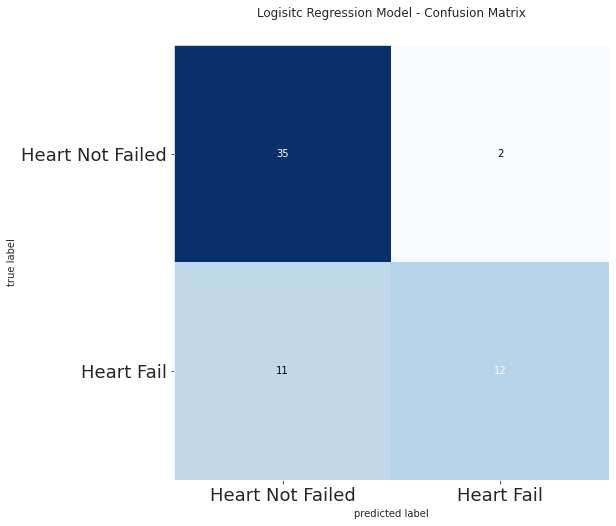

In [ ]:
cm = confusion_matrix(y_test, log_reg_pred)
plt.figure()
plot_confusion_matrix(cm, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.title("Logisitc Regression Model - Confusion Matrix")
plt.xticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=18)
plt.yticks(range(2), ['Heart Not Failed', 'Heart Fail'], fontsize=18)

#### Support Vector Machine

In [ ]:
sv = SVC()
sv.fit(X_train, y_train)
sv_pred = sv.predict(X_test)
sv_acc = accuracy_score(y_test, sv_pred)
print("Accuracy of SVM is : ", "{:.2f}%".format(100* sv_acc))
accuracy_list.append(100*sv_acc)

Accuracy of SVM is :  83.33%


([<matplotlib.axis.YTick at 0x7f113b94db90>,
 [Text(0, 0, 'Heart Not Failed'), Text(0, 0, 'Heart Fail')])

<Figure size 1440x576 with 0 Axes>

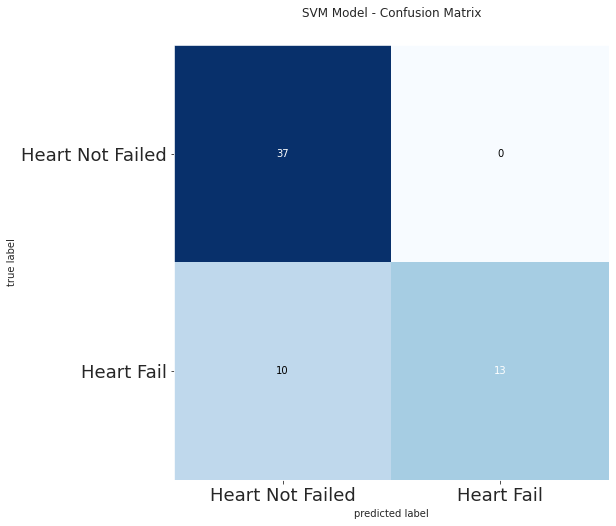

In [ ]:
cm = confusion_matrix(y_test, sv_pred)
plt.figure()
plot_confusion_matrix(cm, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.title("SVM Model - Confusion Matrix")
plt.xticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=18)
plt.yticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=18)

#### KNN

In [ ]:
knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)
knn_acc = accuracy_score(y_test, knn_pred)
print("Accuracy of K Neighbors Classifier is : ", "{:.2f}%".format(100* knn_acc))
accuracy_list.append(100*knn_acc)

Accuracy of K Neighbors Classifier is :  80.00%


<Figure size 1440x576 with 0 Axes>

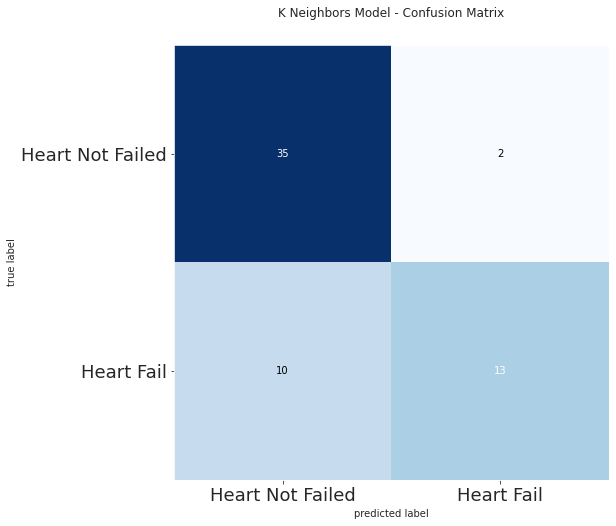

In [ ]:
cm = confusion_matrix(y_test, knn_pred)
plt.figure()
plot_confusion_matrix(cm, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.title("K Neighbors Model - Confusion Matrix")
plt.xticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=18)
plt.yticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=18)
plt.show()

#### Decision Tree

In [ ]:
dt = DecisionTreeClassifier(max_leaf_nodes=3, random_state=0, criterion='entropy')
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)
dt_acc = accuracy_score(y_test, dt_pred)
print("Accuracy of Decision Tree Classifier is : ", "{:.2f}%".format(100* dt_acc))
accuracy_list.append(100*dt_acc)

Accuracy of Decision Tree Classifier is :  81.67%


<Figure size 1440x576 with 0 Axes>

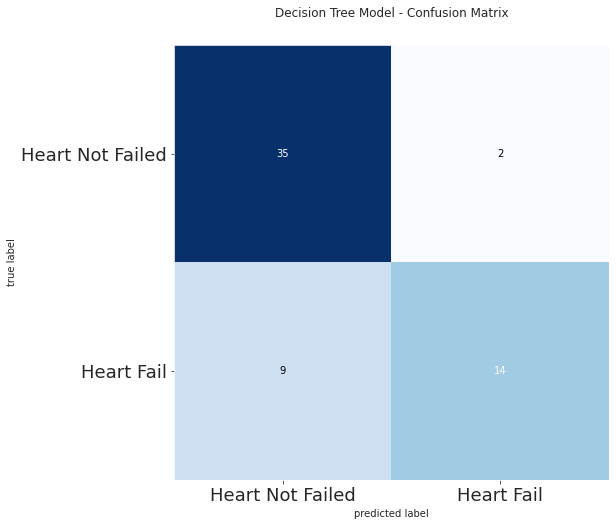

In [ ]:
cm = confusion_matrix(y_test, dt_pred)
plt.figure()
plot_confusion_matrix(cm, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.title("Decision Tree Model - Confusion Matrix")
plt.xticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=18)
plt.yticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=18)
plt.show()

#### Random Forest Classifier

In [ ]:
rf = RandomForestClassifier(max_features=0.5, max_depth=15, random_state=1)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_acc = accuracy_score(y_test, rf_pred)
print("Accuracy of Random Forest Classifier is : ", "{:.2f}%".format(100* rf_acc))
accuracy_list.append(100*rf_acc)

Accuracy of Random Forest Classifier is :  85.00%


([<matplotlib.axis.YTick at 0x7f113ba125d0>,
 [Text(0, 0, 'Heart Not Failed'), Text(0, 0, 'Heart Fail')])

<Figure size 1440x576 with 0 Axes>

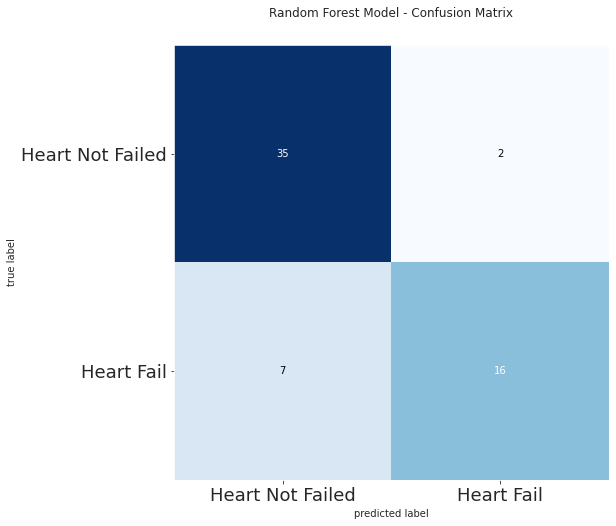

In [ ]:
cm = confusion_matrix(y_test, rf_pred)
plt.figure()
plot_confusion_matrix(cm, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.title("Random Forest Model - Confusion Matrix")
plt.xticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=18)
plt.yticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=18)

#### GradientBoost

In [ ]:
gradientboost = GradientBoostingClassifier(max_depth=2, random_state=1)
gradientboost.fit(X_train,y_train)
gradientboost_pred = gradientboost.predict(X_test)
gradientboost_acc = accuracy_score(y_test, gradientboost_pred)
print("Accuracy of Gradient Boosting is : ", "{:.2f}%".format(100* gradientboost_acc))
accuracy_list.append(100*gradientboost_acc)

Accuracy of Gradient Boosting is :  85.00%


([<matplotlib.axis.YTick at 0x7f113a7a8390>,
 [Text(0, 0, 'Heart Not Failed'), Text(0, 0, 'Heart Fail')])

<Figure size 1440x576 with 0 Axes>

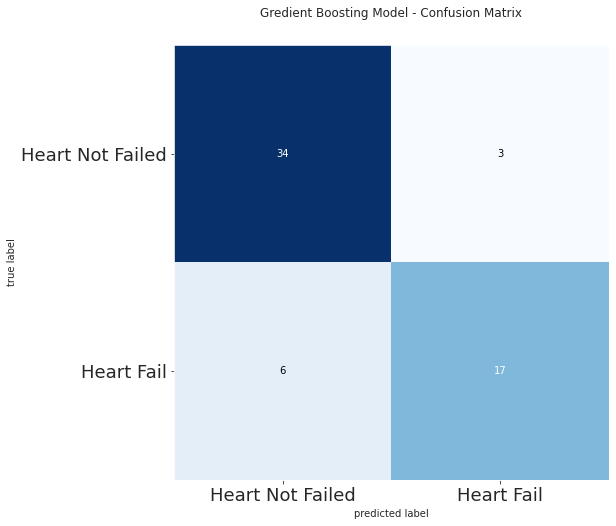

In [ ]:
cm = confusion_matrix(y_test, gradientboost_pred)
plt.figure()
plot_confusion_matrix(cm, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.title("Gredient Boosting Model - Confusion Matrix")
plt.xticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=18)
plt.yticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=18)

#### xgbrf classifier

In [ ]:
xgb = xgboost.XGBRFClassifier(max_depth=3, random_state=1)
xgb.fit(X_train,y_train)
xgb_pred = xgb.predict(X_test)
xgb_acc = accuracy_score(y_test, xgb_pred)
print("Accuracy of XGBRFClassifier is : ", "{:.2f}%".format(100* xgb_acc))
accuracy_list.append(100*xgb_acc)

Accuracy of XGBRFClassifier is :  83.33%


([<matplotlib.axis.YTick at 0x7f113a7d1ed0>,
 [Text(0, 0, 'Heart Not Failed'), Text(0, 0, 'Heart Fail')])

<Figure size 1440x576 with 0 Axes>

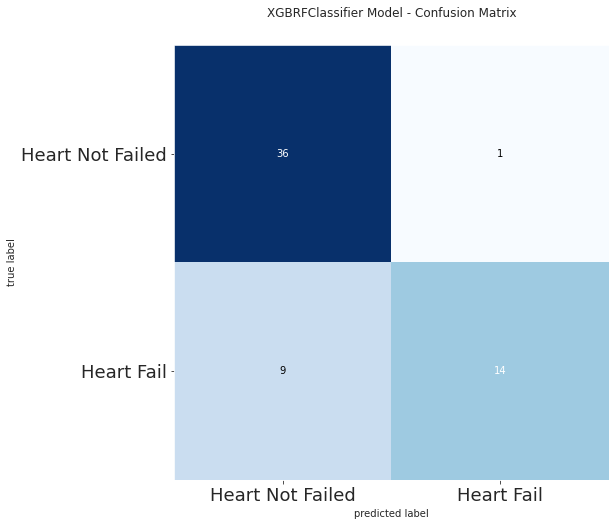

In [ ]:
cm = confusion_matrix(y_test, xgb_pred)
plt.figure()
plot_confusion_matrix(cm, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.title("XGBRFClassifier Model - Confusion Matrix")
plt.xticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=18)
plt.yticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=18)

#### LGBMClassifier

In [ ]:
lgb = lightgbm.LGBMClassifier(max_depth=2, random_state=4)
lgb.fit(X_train,y_train)
lgb_pred = lgb.predict(X_test)
lgb_acc = accuracy_score(y_test, lgb_pred)
print("Accuracy of LGBMClassifier is : ","{:.2f}%".format(100* lgb_acc))
accuracy_list.append(100*lgb_acc)

Accuracy of LGBMClassifier is :  85.00%


([<matplotlib.axis.YTick at 0x7f113a6d2110>,
 [Text(0, 0, 'Heart Not Failed'), Text(0, 0, 'Heart Fail')])

<Figure size 1440x576 with 0 Axes>

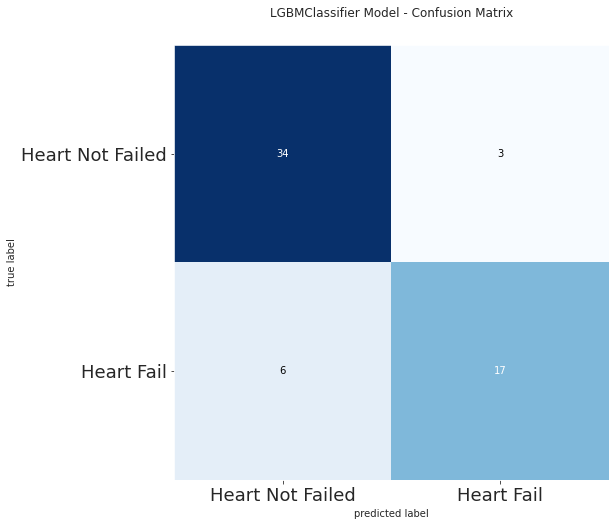

In [ ]:
cm = confusion_matrix(y_test, lgb_pred)
plt.figure()
plot_confusion_matrix(cm, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.title("LGBMClassifier Model - Confusion Matrix")
plt.xticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=18)
plt.yticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=18)

#### Cat Boost Classifier

In [ ]:
cat = CatBoostClassifier()
cat.fit(X_train,y_train)
cat_pred = cat.predict(X_test)
cat_acc = accuracy_score(y_test, cat_pred)
print("Accuracy of CatBoostClassifier is : ","{:.2f}%".format(100* cat_acc))
accuracy_list.append(100*cat_acc)

Learning rate set to 0.005591
0:	learn: 0.6885351	total: 640us	remaining: 640ms
1:	learn: 0.6835128	total: 2.94ms	remaining: 1.47s
2:	learn: 0.6792102	total: 4.46ms	remaining: 1.48s
3:	learn: 0.6742260	total: 5.9ms	remaining: 1.47s
4:	learn: 0.6707319	total: 7.31ms	remaining: 1.45s
5:	learn: 0.6665215	total: 8.66ms	remaining: 1.44s
6:	learn: 0.6622422	total: 9.53ms	remaining: 1.35s
7:	learn: 0.6590950	total: 10.2ms	remaining: 1.26s
8:	learn: 0.6541695	total: 11ms	remaining: 1.21s
9:	learn: 0.6499864	total: 11.9ms	remaining: 1.18s
10:	learn: 0.6463276	total: 12.5ms	remaining: 1.12s
11:	learn: 0.6420706	total: 13.2ms	remaining: 1.08s
12:	learn: 0.6382611	total: 14.2ms	remaining: 1.08s
13:	learn: 0.6344413	total: 15.2ms	remaining: 1.07s
14:	learn: 0.6306535	total: 16.1ms	remaining: 1.06s
15:	learn: 0.6271396	total: 17ms	remaining: 1.05s
16:	learn: 0.6235436	total: 17.9ms	remaining: 1.04s
17:	learn: 0.6195527	total: 18.9ms	remaining: 1.03s
18:	learn: 0.6155531	total: 19.8ms	remaining: 1.02

([<matplotlib.axis.YTick at 0x7f113a6a7050>,
 [Text(0, 0, 'Heart Not Failed'), Text(0, 0, 'Heart Fail')])

<Figure size 1440x576 with 0 Axes>

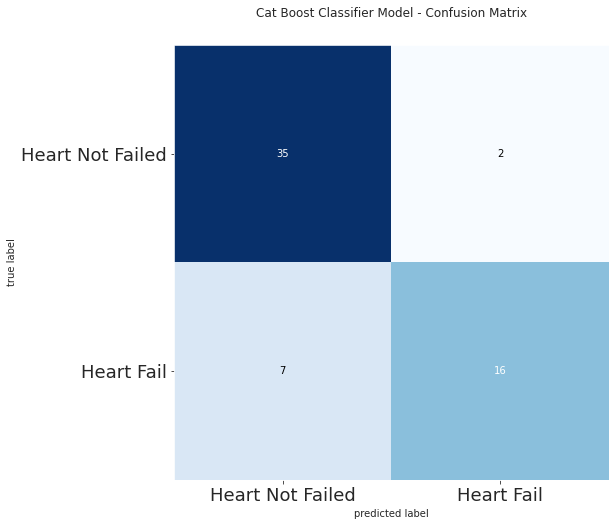

In [ ]:
cm = confusion_matrix(y_test, cat_pred)
plt.figure()
plot_confusion_matrix(cm, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.title("Cat Boost Classifier Model - Confusion Matrix")
plt.xticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=18)
plt.yticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=18)

### Performance Evaluation

In [ ]:
model_list = ['Logistic Regression', 'SVC','KNearestNeighbours', 'DecisionTree', 'RandomForest',
              'GradientBooster', 'XGBRF','LGBM', 'CatBoostClassifier']

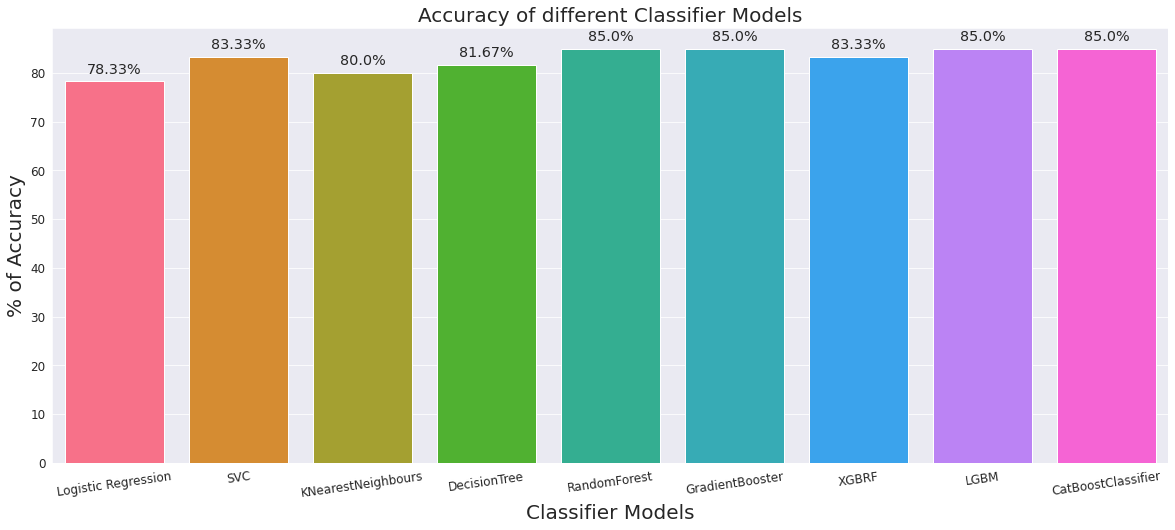

In [ ]:
plt.rcParams['figure.figsize']=20,8
sns.set_style('darkgrid')
ax = sns.barplot(x=model_list, y=accuracy_list, palette = "husl", saturation =2.0)
plt.xlabel('Classifier Models', fontsize = 20 )
plt.ylabel('% of Accuracy', fontsize = 20)
plt.title('Accuracy of different Classifier Models', fontsize = 20)
plt.xticks(fontsize = 12, horizontalalignment = 'center', rotation = 8)
plt.yticks(fontsize = 12)
for i in ax.patches:
    width, height = i.get_width(), i.get_height()
    x, y = i.get_xy() 
    ax.annotate(f'{round(height,2)}%', (x + width/2, y + height*1.02), ha='center', fontsize = 'x-large')